In [52]:
import numpy as np
from matplotlib import pyplot as plt
from halotools import sim_manager
from scipy import optimize
from scipy.stats import norm
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
from scipy import fftpack
from scipy.fftpack import fftfreq, fftshift, ifftshift, ifftn

/u/ayannam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [53]:
Lbox = 512.0 # size of box in Mpc/h
Ngrid = 256 # number of cells in 1D of grid for power spectrum
bin_centers = np.arange(Ngrid) # integer linear space up to number of cells for as bin centers
Lgrid = Lbox / Ngrid # the size of each individual grid cell

In [54]:
columns_dict ={
		"halo_id": 	(0, 'i8'),
		"halo_mvir": 	(2, 'f4'),
        "halo_vmax":    (3, 'f4'),
		"halo_rvir":    (5, 'f4'),
        "halo_rs":      (6, 'f4'),
		"halo_x": 	(8, 'f4'),
		"halo_y": 	(9, 'f4'),
		"halo_z": 	(10,'f4'),
        "halo_spin":(17, 'f4'),
		"PID":		(41,'i8')
	       }

def read_cat(cat_filename):
    reader = sim_manager.TabularAsciiReader(cat_filename, columns_dict)
    halo_arr = reader.read_ascii() # array of tuples containing values for each item in columns_dict
    halo_pos_arr = np.array([halo_arr["halo_x"], halo_arr["halo_y"], halo_arr["halo_z"]]).T #array of arrays containing the x, y, z positions of the halo
    halo_mass_arr = np.log10(halo_arr["halo_mvir"]) # array of log base 10 of the halo masses
    halo_rs_arr = np.array(halo_arr["halo_rs"])
    halo_rvir_arr = np.array(halo_arr["halo_rvir"])
    halo_PID_arr = np.array(halo_arr["PID"])
    return halo_pos_arr, halo_mass_arr, halo_rs_arr, halo_rvir_arr, halo_PID_arr

In [55]:
pos, mass, rs, rvir, PID = read_cat("/u/ayannam/Documents/Test_Files/out_66_parents.list")


...Processing ASCII data of file: 
/u/ayannam/Documents/Test_Files/out_66_parents.list
 
Total number of rows in detected data = 3297686
Number of rows in detected header = 16 

... working on chunk 0 of 2
... working on chunk 1 of 2
Total runtime to read in ASCII = 21.67 seconds




In [58]:
def get_init_density(mass, rs, rvir):
    init_density = mass - np.log10(4 * np.pi) - 2 * np.log10(rs) - (np.log10(np.log(1 + rvir / rs) - (rvir / (rs + rvir))))
    return init_density

In [81]:
def plot_density(mass_filename, rs_filename, rvir_filename, PID_filename):
    
    mass = np.load(mass_filename)
    rs = np.load(rs_filename)
    rvir = np.load(rvir_filename)
    PID = np.load(PID_filename)
    
    init_density = get_init_density(mass, rs, rvir)
    
    parents_mask = PID == -1 # boolean array with True for parent halos and False for subhalos
    subhalo_mask = PID != -1 # boolean array with True for subhalos and False for parent halos
    
    mass_mean = np.mean(mass)
    init_density_mean = np.mean(init_density[parents_mask])
    
    hist, bins = np.histogram(init_density[parents_mask], bins = 50)
    
    plt.hist(init_density[parents_mask], label = "log10 peak density", bins = 50)
    plt.hist(mass[parents_mask], label = "log10 mass", bins = 50)

    plt.axvline(x = mass_mean, color = "k")
    plt.axvline(x = init_density_mean, color = "k")
    
    mu, std = norm.fit(init_density[parents_mask])
    height = np.max(hist) * (np.sqrt(2 * np.pi) * std)
    xs = np.linspace(np.min(init_density[parents_mask]), np.max(init_density[parents_mask]))
    
    plt.plot(xs, height * norm.pdf(xs, mu, std), color = "k")

    plt.title("(7/16/18) Histogram of Halo Masses and Peak Densities")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=3)
    plt.show()
    
    eps = 0.001
    xs = np.linspace(eps, np.max(rvir / rs), len(init_density[parents_mask]))
    plt.hist2d(xs, init_density[parents_mask] - np.log10(xs + 2 * xs ** 2 + xs ** 3), bins = (100, 100))
    plt.title("(7/17/18) Halo Densities Versus R = r / rs")
    plt.xlabel("R = r / rs")
    plt.ylabel("Log10 Halo Densities")
    plt.show()
    
    xs = np.linspace(eps, 1, len(init_density[parents_mask]))
    plt.hist2d(xs, init_density[parents_mask] - np.log10(xs + 2 * xs ** 2 + xs ** 3), bins = (100, 100))
    plt.title("(7/17/18) Halo Densities Versus R = r / rvir")
    plt.xlabel("R = r / rvir")
    plt.ylabel("Log10 Halo Densities")
    binned = np.linspace(0, 1, 100)
    
    means = binned_statistic(xs, init_density[parents_mask] - np.log10(xs + 2 * xs ** 2 + xs ** 3), bins = 100)[0]
    plt.plot(binned, means, color = 'r')
    plt.show()
# This graph shows that the halos are not all described fully by their masses, and they are not just shifted by the
# additional terms when calculating densities

    rad = np.linspace(eps, 1, len(mass[parents_mask]))
    con = (rvir / rs)[parents_mask]
    mass_profile = mass[parents_mask] + np.log10(np.log(1 + rad) + rad / (1 + rad)) + np.log10(np.log(1 + con) + con / (1 + con))
    plt.hist2d(rad, mass_profile, bins = (100, 100))
    plt.show()


In [82]:
mnv0z0mass = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_66_parents_mass.npy"
mnv1z0mass = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_66_parents_mass.npy"
mnv6z0mass = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_66_parents_mass.npy"

mnv0z0PID = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_66_parents_PID.npy"
mnv1z0PID = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_66_parents_PID.npy"
mnv6z0PID = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_66_parents_PID.npy"

mnv0z0rs = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_66_rs.npy"
mnv1z0rs = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_66_rs.npy"
mnv6z0rs = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_66_rs.npy"

mnv0z0rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_66_rvir.npy"
mnv1z0rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_66_rvir.npy"
mnv6z0rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_66_rvir.npy"


mnv0z05mass = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_56_parents_mass.npy"
mnv1z05mass = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_56_parents_mass.npy"
mnv6z05mass = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_56_parents_mass.npy"

mnv0z05PID = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_56_parents_PID.npy"
mnv1z05PID = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_56_parents_PID.npy"
mnv6z05PID = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_56_parents_PID.npy"

mnv0z05rs = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_56_rs.npy"
mnv1z05rs = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_56_rs.npy"
mnv6z05rs = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_56_rs.npy"

mnv0z05rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_56_rvir.npy"
mnv1z05rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_56_rvir.npy"
mnv6z05rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_56_rvir.npy"


mnv0z1mass = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_47_parents_mass.npy"
mnv1z1mass = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_47_parents_mass.npy"
mnv6z1mass = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_47_parents_mass.npy"

mnv0z1PID = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_47_parents_PID.npy"
mnv1z1PID = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_47_parents_PID.npy"
mnv6z1PID = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_47_parents_PID.npy"

mnv0z1rs = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_47_rs.npy"
mnv1z1rs = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_47_rs.npy"
mnv6z1rs = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_47_rs.npy"

mnv0z1rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_47_rvir.npy"
mnv1z1rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_47_rvir.npy"
mnv6z1rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_47_rvir.npy"


mnv0z15mass = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_42_parents_mass.npy"
mnv1z15mass = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_42_parents_mass.npy"
mnv6z15mass = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_42_parents_mass.npy"

mnv0z15PID = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_42_parents_PID.npy"
mnv1z15PID = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_42_parents_PID.npy"
mnv6z15PID = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_42_parents_PID.npy"

mnv0z15rs = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_42_rs.npy"
mnv1z15rs = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_42_rs.npy"
mnv6z15rs = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_42_rs.npy"

mnv0z15rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_42_rvir.npy"
mnv1z15rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_42_rvir.npy"
mnv6z15rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_42_rvir.npy"


mnv0z2mass = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_47_parents_mass.npy"
mnv1z2mass = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_47_parents_mass.npy"
mnv6z2mass = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_47_parents_mass.npy"

mnv0z2PID = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_47_parents_PID.npy"
mnv1z2PID = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_47_parents_PID.npy"
mnv6z2PID = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_47_parents_PID.npy"

mnv0z2rs = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_47_rs.npy"
mnv1z2rs = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_47_rs.npy"
mnv6z2rs = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_47_rs.npy"

mnv0z2rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.0/out_47_rvir.npy"
mnv1z2rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_47_rvir.npy"
mnv6z2rvir = "/u/ayannam/Documents/Raw_Data/mnv_0.6/out_47_rvir.npy"

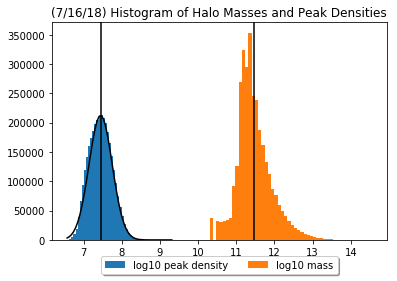

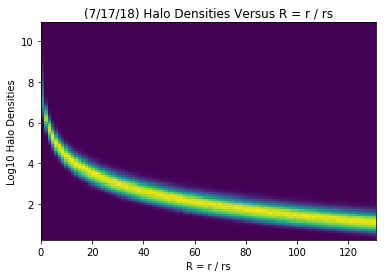

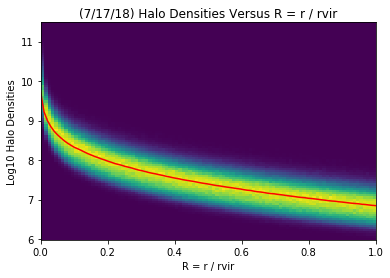

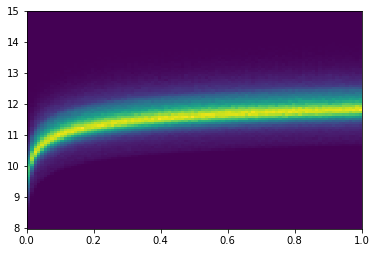

In [83]:
plot_density(mnv6z2mass, mnv6z2rs, mnv6z2rvir, mnv6z2PID)

In [84]:
def azimuthalAverage3D(grid, edges = None, logbins = True, bins = 50):
    z, y, x = np.indices(grid.shape)
    icenter=(x.max()-x.min())/2.0
    center = np.array([icenter, icenter, icenter])
     
    if grid.shape[0]%2 == 0:
        center+=0.5
     
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)#distance to center pixel, for each pixel
 
    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind] # the index to sort by r
    i_sorted = grid.flat[ind] # the index of the images sorted by r
 
    # find index that's corresponding to the lower edge of each bin
    kmin=1.0
    kmax=grid.shape[0]/2.0
    if edges == None:
        if logbins:
            edges = np.logspace(np.log10(kmin),np.log10(kmax),bins+1)
        else:
            #edges = linspace(kmin,kmax+0.001,bins+1)    
            edges = np.linspace(kmin,kmax,bins+1)
    if edges[0] > 0:
        edges = np.append([0],edges)
         
    hist_ind = np.histogram(r_sorted,bins = edges)[0] # hist_ind: the number in each ell bins, sum them up is the index of lower edge of each bin, first bin spans from 0 to left of first bin edge.    
    hist_sum = np.cumsum(hist_ind)
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[hist_sum[1:]] - csim[hist_sum[:-1]]
    radial_prof = tbin / hist_ind[1:]
    return edges[1:], radial_prof

edge2center = lambda x: x[:-1]+0.5*(x[1:]-x[:-1])

def PowerSpectrum3D(grid, logbins = True, bins=50):
    # Calculate the power spectrum for a cube.
    # Input:
    # grid = input grid in numpy array.
    # Output:
    # k, psd1D
    isize = grid.shape[0]
    F = fftshift(fftpack.fftn(grid))
    psd3D = np.abs(F)**2
    k_arr, psd1D = azimuthalAverage3D(psd3D, logbins = logbins, bins=bins)
    k_arr = edge2center(k_arr)
    return k_arr, psd1D
 
def process_ps_density(grid):
    '''
    Comoput the power spectrum giving the positions of particles/halos.
    Input:
    The positions, output from either read_cat, or read_subsample
    Output: 
    k_normed: the k bin center
    ps3d_normed: the power spectrum
    '''
    k, ps3d = PowerSpectrum3D(grid)
    k_normed, ps3d_normed = 2*np.pi*k/Lbox, ps3d*(Lgrid/Ngrid)**3
    return k_normed, ps3d_normed


def gridding(halo_positions):
    # returns a 3D grid of the density of halos
    grid = np.histogramdd(halo_positions / Lgrid, bins = [bin_centers, bin_centers, bin_centers])[0]
    grid = grid / np.mean(grid) - 1
    return grid

def process_ps_grid(igrid):
    '''
    Comoput the power spectrum giving the positions of particles/halos.
    Input:
    The positions, output from either read_cat, or read_subsample
    Output: 
    k_normed: the k bin center
    ps3d_normed: the power spectrum
    '''
    k, ps3d = PowerSpectrum3D(igrid)
    k_normed, ps3d_normed = 2*np.pi*k/Lbox, ps3d*(Lgrid/Ngrid)**3
    return k_normed, ps3d_normed

def plot_phh_with_mass_init_density(halo_positions, init_density_arr, mass_arr, PID_arr):
    
    parents_mask = PID == -1
    mass_mean = np.mean(mass_arr)
    init_density_mean = np.mean(init_density_arr)

    mass_upper_mask = mass_arr >= mass_mean
    mass_lower_mask = mass_arr < mass_mean
    mass_upper_mask = mass_upper_mask & parents_mask
    mass_lower_mask = mass_lower_mask & parents_mask
    masses = mass_arr
    mass_g12_mask = masses >= 12
    mass_l13_mask = masses < 13
    mass_12_13_mask = mass_g12_mask & mass_l13_mask
    mass_12_13_mask = mass_12_13_mask & parents_mask
    
    mass_g13_mask = masses >= 13
    mass_l14_mask = masses < 14
    mass_13_14_mask = mass_g13_mask & mass_l14_mask
    mass_13_14_mask = mass_13_14_mask & parents_mask
    
    mass_g14_mask = masses >= 14
    mass_l15_mask = masses < 15
    mass_14_15_mask = mass_g14_mask & mass_l15_mask
    mass_14_15_mask = mass_14_15_mask & parents_mask
    
    grid_12_13 = gridding(halo_positions[mass_12_13_mask])
    grid_13_14 = gridding(halo_positions[mass_13_14_mask])
    grid_14_15 = gridding(halo_positions[mass_14_15_mask])
    
    k12, p12 = process_ps_grid(grid_12_13)
    k13, p13 = process_ps_grid(grid_13_14)
    k14, p14 = process_ps_grid(grid_14_15)
    
    
    
    init_density_upper_mask = init_density_arr >= mass_mean
    init_density_lower_mask = init_density_arr < mass_mean
    init_density_upper_mask = init_density_upper_mask & parents_mask
    init_density_lower_mask = init_density_lower_mask & parents_mask
    
    grid_mass_upper = gridding(halo_positions[mass_upper_mask])
    grid_mass_lower = gridding(halo_positions[mass_lower_mask])
    grid_init_density_upper = gridding(halo_positions[init_density_upper_mask])
    grid_init_density_lower = gridding(halo_positions[init_density_lower_mask])
    
    kmu, pmu = process_ps_grid(grid_mass_upper)
    kml, pml = process_ps_grid(grid_mass_lower)
    kdu, pdu = process_ps_grid(grid_init_density_upper)
    kdl, pdl = process_ps_grid(grid_init_density_lower)
    
    #plt.plot(kmu, pmu, label = "high mass")
    #plt.plot(kml, pml, label = "low mass")
    plt.plot(kdu, pdu,  "x", label = "high peak density")
    plt.plot(kdl, pdl, "x", label = "low peak density")
    
    plt.plot(k12, p12, label = "mass = 12-13")
    plt.plot(k13, p13, label = "mass = 13-14")
    plt.plot(k14, p14, label = "mass = 14-15")
    
    plt.title("(7/16/18) log-log Halo Power Spectrum With Split Halo Mass and Initial Density, MNV = 0.0, z = 0")
    plt.xlabel("log(k) (log(1/r))")
    plt.ylabel("Power Density (log10(mass))")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=3)
    plt.show()

In [61]:
def generate_normal_density_matrix():
    
    averages = np.zeros((3, 5))
    stddevs = np.zeros((3, 5))
    
    redshifts = ["66", "56", "47", "42", "37"]
    mnvs = ["0.0", "0.1", "0.6"]
    redshifts_count = -1
    for z in redshifts:
        redshifts_count = redshifts_count + 1
        mnv_count = 0
        for m in mnvs:
            
            masses = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + m + "/out_" + z + "_parents_mass.npy")
            rs = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + m + "/out_" + z + "_rs.npy")
            rvir = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + m + "/out_" + z + "_rvir.npy")
            PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + m + "/out_" + z + "_parents_PID.npy")
            
            init_density = get_init_density(masses, rs, rvir)
    
            parents_mask = PID == -1 # boolean array with True for parent halos and False for subhalos
            subhalo_mask = PID != -1 # boolean array with True for subhalos and False for parent halos
            
            mu, std = norm.fit(init_density[parents_mask])
            averages[mnv_count][redshifts_count] = mu
            stddevs[mnv_count][redshifts_count] = std
            
            mnv_count = mnv_count + 1
    
    return averages, stddevs

In [62]:
mu, std = generate_normal_density_matrix()

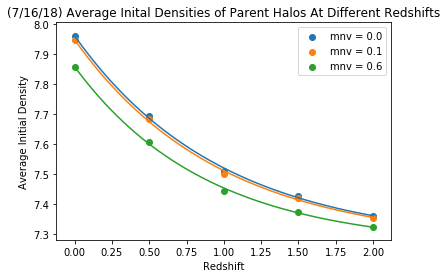

mnv = 0.0 mu equation: 0.689614935098403 * exp(-1.0174283384146445 * z) + 7.271309480372792
mnv = 0.1 mu equation: 0.6782909405592401 * exp(-1.0299110212281586 * z) + 7.2694669303267085
mnv = 0.6 mu equation: 0.5970001984426161 * exp(-1.1286090756518419 * z) + 7.260892586202531


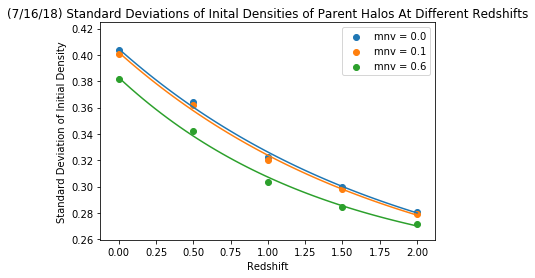

mnv = 0.0 std equation: 0.19094909957602824 * exp(-0.5289791148450297 * z) + 0.2136755196544389
mnv = 0.1 std equation: 0.18683344698603646 * exp(-0.5419516059933037 * z) + 0.21510213287124866
mnv = 0.6 std equation: 0.1485343591935396 * exp(-0.7113918861631178 * z) + 0.2342677303971418


In [63]:
redshifts = [0, 0.5, 1, 1.5, 2]
plt.scatter(redshifts, mu[0], label = "mnv = 0.0")
plt.scatter(redshifts, mu[1], label = "mnv = 0.1")
plt.scatter(redshifts, mu[2], label = "mnv = 0.6")
plt.xlabel("Redshift")
plt.ylabel("Average Initial Density")
plt.title("(7/16/18) Average Inital Densities of Parent Halos At Different Redshifts")
mnv0_mu_coeffs, _ = optimize.curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, redshifts, mu[0])
mnv1_mu_coeffs, _ = optimize.curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, redshifts, mu[1])
mnv6_mu_coeffs, _ = optimize.curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, redshifts, mu[2])
xs = np.linspace(0, 2)
plt.plot(xs, mnv0_mu_coeffs[0] * np.exp(-mnv0_mu_coeffs[1] * xs) + mnv0_mu_coeffs[2])
plt.plot(xs, mnv1_mu_coeffs[0] * np.exp(-mnv1_mu_coeffs[1] * xs) + mnv1_mu_coeffs[2])
plt.plot(xs, mnv6_mu_coeffs[0] * np.exp(-mnv6_mu_coeffs[1] * xs) + mnv6_mu_coeffs[2])
plt.legend()
plt.show()
print("mnv = 0.0 mu equation: " + str(mnv0_mu_coeffs[0]) + " * exp(-" +  str(mnv0_mu_coeffs[1]) + " * z) + " + str(mnv0_mu_coeffs[2]))
print("mnv = 0.1 mu equation: " + str(mnv1_mu_coeffs[0]) + " * exp(-" +  str(mnv1_mu_coeffs[1]) + " * z) + " + str(mnv1_mu_coeffs[2]))
print("mnv = 0.6 mu equation: " + str(mnv6_mu_coeffs[0]) + " * exp(-" +  str(mnv6_mu_coeffs[1]) + " * z) + " + str(mnv6_mu_coeffs[2]))

plt.scatter(redshifts, std[0], label = "mnv = 0.0")
plt.scatter(redshifts, std[1], label = "mnv = 0.1")
plt.scatter(redshifts, std[2], label = "mnv = 0.6")
plt.xlabel("Redshift")
plt.ylabel("Standard Deviation of Initial Density")
plt.title("(7/16/18) Standard Deviations of Inital Densities of Parent Halos At Different Redshifts")
mnv0_std_coeffs, _ = optimize.curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, redshifts, std[0])
mnv1_std_coeffs, _ = optimize.curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, redshifts, std[1])
mnv6_std_coeffs, _ = optimize.curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, redshifts, std[2])
xs = np.linspace(0, 2)
plt.plot(xs, mnv0_std_coeffs[0] * np.exp(-mnv0_std_coeffs[1] * xs) + mnv0_std_coeffs[2])
plt.plot(xs, mnv1_std_coeffs[0] * np.exp(-mnv1_std_coeffs[1] * xs) + mnv1_std_coeffs[2])
plt.plot(xs, mnv6_std_coeffs[0] * np.exp(-mnv6_std_coeffs[1] * xs) + mnv6_std_coeffs[2])
plt.legend()
plt.show()
print("mnv = 0.0 std equation: " + str(mnv0_std_coeffs[0]) + " * exp(-" +  str(mnv0_std_coeffs[1]) + " * z) + " + str(mnv0_std_coeffs[2]))
print("mnv = 0.1 std equation: " + str(mnv1_std_coeffs[0]) + " * exp(-" +  str(mnv1_std_coeffs[1]) + " * z) + " + str(mnv1_std_coeffs[2]))
print("mnv = 0.6 std equation: " + str(mnv6_std_coeffs[0]) + " * exp(-" +  str(mnv6_std_coeffs[1]) + " * z) + " + str(mnv6_std_coeffs[2]))


/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


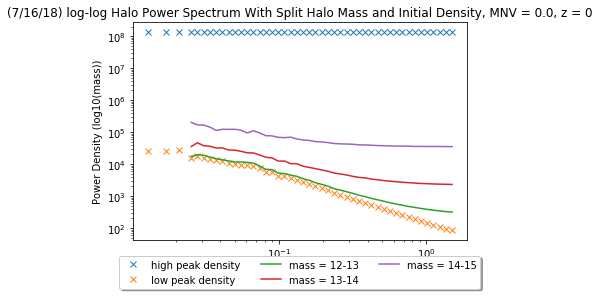

In [85]:
init_density = get_init_density(mass, rs, rvir)
plot_phh_with_mass_init_density(pos, init_density, mass, PID)

In [65]:
print(np.mean(rvir))

164.45657


In [241]:
print(np.mean(rs))

20.256285
